## Pyhealth Kaggle Example

This notebook demonstrates how to use PyHealth to load and train a model on a public dataset from Kaggle.
In particular, we will use the Chest X-Ray Pneumonia dataset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


### Dependencies
1. download PyHealth
2. downgrade protobuf to avoid depdendecieis conflict with Kaggle env
```bash
pip install git+https://github.com/rz-coder/PyHealth.git
pip install "protobuf<=3.20.3"
```

In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:

# This will be the input dir path
kaggle_root = "/kaggle/input/chest-xray-pneumonia/chest_xray"

In [4]:
import os
import pandas as pd
import yaml
from pathlib import Path
from typing import Dict, List, Optional
import shutil
from PIL import Image
import numpy as np
import torch

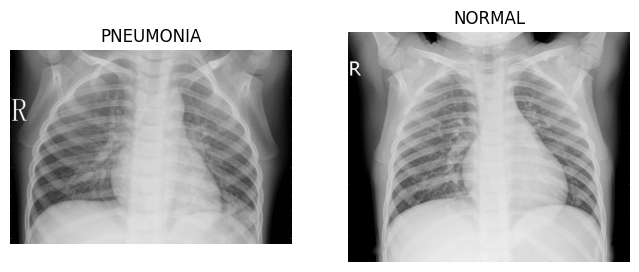

In [25]:
import torchvision.transforms as T
import matplotlib.pyplot as plt

path_pneumonia = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1950_bacteria_4881.jpeg"
path_normal = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg"


transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

# Load images
img_pneumonia = Image.open(path_pneumonia).convert("L")
img_normal = Image.open(path_normal).convert("L")

tensor_pneumonia = transform(img_pneumonia)
tensor_normal = transform(img_normal)

fig, axs = plt.subplots(1, 2, figsize=(8,4))

axs[0].imshow(img_pneumonia, cmap="gray")
axs[0].set_title("PNEUMONIA")
axs[0].axis("off")

axs[1].imshow(img_normal, cmap="gray")
axs[1].set_title("NORMAL")
axs[1].axis("off")

plt.show()

In [26]:
config_data = {
    "version": "1.0",
    "tables": {
        "pneumonia": {
            "file_path": "metadata.csv",
            "patient_id": "patient_id",
            "attributes": ["path", "label", "split"]
        }
    }
}

# Save the yaml config file
work_dir = "."
config_path = os.path.join(work_dir, "pneumonia.yaml")
with open(config_path, "w") as f:
    yaml.dump(config_data, f)

print(f"Created config file at {config_path}")

Created config file at ./pneumonia.yaml


In [6]:
from pyhealth.datasets import BaseDataset
from pyhealth.tasks import BaseTask
from pyhealth.data import Event, Patient
from pyhealth.datasets import get_dataloader, split_by_sample
from pyhealth.models import TorchvisionModel
from pyhealth.trainer import Trainer

In [7]:
class PneumoniaDataset(BaseDataset):
    def __init__(self, root, config_path=None, dev=False):
        self._index_data(root)
        
        # Initialize BaseDataset
        if config_path is None:
            config_path = "./pneumonia.yaml"
            
        super().__init__(
            root=".",
            tables=["pneumonia"],
            dataset_name="PneumoniaDataset",
            config_path=config_path,
            dev=dev
        )

    def _index_data(self, root):
        data = []
        splits = ["train", "test", "val"]
        classes = {"NORMAL": 0, "PNEUMONIA": 1}
        
        print(f"Scanning dataset at {root}...")
        for split in splits:
            for cls_name, cls_label in classes.items():
                dir_path = os.path.join(root, split, cls_name)
                if not os.path.exists(dir_path):
                    print(f"Warning: Directory not found: {dir_path}")
                    continue
                    
                for img_name in os.listdir(dir_path):
                    if not img_name.lower().endswith(('.jpeg', '.jpg', '.png')):
                        continue
                        
                    img_path = os.path.join(root, split, cls_name, img_name)
                    # Use filename as patient_id for simplicity
                    patient_id = f"{split}_{cls_name}_{img_name.split('.')[0]}"
                    
                    data.append({
                        "patient_id": patient_id,
                        "path": img_path,
                        "label": cls_label,
                        "split": split
                    })
        
        df = pd.DataFrame(data)
        df.to_csv("./metadata.csv", index=False)
        print(f"Indexed {len(df)} images to ./metadata.csv")

    @property
    def default_task(self):
        return PneumoniaClassificationTask()

In [8]:
class PneumoniaClassificationTask(BaseTask):
    task_name = "PneumoniaClassification"
    input_schema = {"image": "image"}
    output_schema = {"label": "binary"}

    def __call__(self, patient: Patient) -> List[Dict]:
        samples = []
        # Retrieve events from the 'pneumonia' table
        events = patient.get_events(event_type="pneumonia")
        
        for event in events:
            samples.append({
                "image": event.attr_dict["path"],
                "label": int(event.attr_dict["label"])
            })
        return samples

In [9]:
dataset = PneumoniaDataset(root=kaggle_root)
sample_dataset = dataset.set_task()

Scanning dataset at /kaggle/input/chest-xray-pneumonia/chest_xray...
Indexed 5856 images to ./metadata.csv
Initializing PneumoniaDataset dataset from . (dev mode: False)


INFO:pyhealth.datasets.base_dataset:Initializing PneumoniaDataset dataset from . (dev mode: False)


Scanning table: pneumonia from /kaggle/working/metadata.csv


INFO:pyhealth.datasets.base_dataset:Scanning table: pneumonia from /kaggle/working/metadata.csv


Setting task PneumoniaClassification for PneumoniaDataset base dataset...


INFO:pyhealth.datasets.base_dataset:Setting task PneumoniaClassification for PneumoniaDataset base dataset...


Generating samples with 1 worker(s)...


INFO:pyhealth.datasets.base_dataset:Generating samples with 1 worker(s)...


INFO:pyhealth.datasets.base_dataset:Collecting global event dataframe...


Collected dataframe with shape: (5856, 6)


INFO:pyhealth.datasets.base_dataset:Collected dataframe with shape: (5856, 6)
Generating samples for PneumoniaClassification with 1 worker: 100%|██████████| 5856/5856 [00:02<00:00, 2326.97it/s]

Label label vocab: {0: 0, 1: 1}



INFO:pyhealth.processors.label_processor:Label label vocab: {0: 0, 1: 1}
Processing samples: 100%|██████████| 5856/5856 [01:27<00:00, 67.21it/s]

Generated 5856 samples for task PneumoniaClassification



INFO:pyhealth.datasets.base_dataset:Generated 5856 samples for task PneumoniaClassification


In [10]:
sample_dataset[0]

{'image': tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.4275, 0.4510, 0.4588],
          [0.0000, 0.0000, 0.0000,  ..., 0.4431, 0.4627, 0.4784],
          [0.0000, 0.0000, 0.0000,  ..., 0.4588, 0.4784, 0.5020],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]),
 'label': tensor([0.])}

In [11]:
train_ds, val_ds, test_ds = split_by_sample(sample_dataset, [0.8, 0.1, 0.1])


In [12]:
train_loader = get_dataloader(train_ds, batch_size=32, shuffle=True)
val_loader = get_dataloader(val_ds, batch_size=32, shuffle=False)
test_loader = get_dataloader(test_ds, batch_size=32, shuffle=False)

In [13]:
print(f"Train size: {len(train_ds)}, Val size: {len(val_ds)}, Test size: {len(test_ds)}")

Train size: 4684, Val size: 586, Test size: 586


## Trainning 
Kaggle provide GPU option. If your kernel has GPU, you can use it to train your data. I am usigng Tesla T4 in this notebook

In [14]:
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

CUDA Available: True
GPU Name: Tesla T4


In [16]:
model = TorchvisionModel(
    dataset=sample_dataset,
    model_name="resnet18",
    model_config={"weights": "DEFAULT"} # Use pretrained weights
)

trainer = Trainer(model=model,
                  device="cuda" if torch.cuda.is_available() else "cpu", 
                  metrics=["accuracy", "f1"])
trainer.train(
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=5,
    monitor="accuracy",
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


TorchvisionModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

INFO:pyhealth.trainer:TorchvisionModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentu

Metrics: ['accuracy', 'f1']


INFO:pyhealth.trainer:Metrics: ['accuracy', 'f1']


Device: cuda


INFO:pyhealth.trainer:Device: cuda


INFO:pyhealth.trainer:


Training:


INFO:pyhealth.trainer:Training:


Batch size: 32


INFO:pyhealth.trainer:Batch size: 32


Optimizer: <class 'torch.optim.adam.Adam'>


INFO:pyhealth.trainer:Optimizer: <class 'torch.optim.adam.Adam'>


Optimizer params: {'lr': 0.001}


INFO:pyhealth.trainer:Optimizer params: {'lr': 0.001}


Weight decay: 0.0


INFO:pyhealth.trainer:Weight decay: 0.0


Max grad norm: None


INFO:pyhealth.trainer:Max grad norm: None


Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7bccf8939f90>


INFO:pyhealth.trainer:Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7bccf8939f90>


Monitor: accuracy


INFO:pyhealth.trainer:Monitor: accuracy


Monitor criterion: max


INFO:pyhealth.trainer:Monitor criterion: max


Epochs: 5


INFO:pyhealth.trainer:Epochs: 5


Patience: None


INFO:pyhealth.trainer:Patience: None


INFO:pyhealth.trainer:


Epoch 0 / 5:   0%|          | 0/147 [00:00<?, ?it/s]

--- Train epoch-0, step-147 ---


INFO:pyhealth.trainer:--- Train epoch-0, step-147 ---


loss: 0.1750


INFO:pyhealth.trainer:loss: 0.1750
Evaluation: 100%|██████████| 19/19 [00:00<00:00, 30.35it/s]

--- Eval epoch-0, step-147 ---



INFO:pyhealth.trainer:--- Eval epoch-0, step-147 ---


accuracy: 0.9096


INFO:pyhealth.trainer:accuracy: 0.9096


f1: 0.9426


INFO:pyhealth.trainer:f1: 0.9426


loss: 0.4396


INFO:pyhealth.trainer:loss: 0.4396


New best accuracy score (0.9096) at epoch-0, step-147


INFO:pyhealth.trainer:New best accuracy score (0.9096) at epoch-0, step-147


INFO:pyhealth.trainer:


Epoch 1 / 5:   0%|          | 0/147 [00:00<?, ?it/s]

--- Train epoch-1, step-294 ---


INFO:pyhealth.trainer:--- Train epoch-1, step-294 ---


loss: 0.1154


INFO:pyhealth.trainer:loss: 0.1154
Evaluation: 100%|██████████| 19/19 [00:00<00:00, 33.40it/s]

--- Eval epoch-1, step-294 ---



INFO:pyhealth.trainer:--- Eval epoch-1, step-294 ---


accuracy: 0.7918


INFO:pyhealth.trainer:accuracy: 0.7918


f1: 0.8799


INFO:pyhealth.trainer:f1: 0.8799


loss: 0.6418


INFO:pyhealth.trainer:loss: 0.6418


INFO:pyhealth.trainer:


Epoch 2 / 5:   0%|          | 0/147 [00:00<?, ?it/s]

--- Train epoch-2, step-441 ---


INFO:pyhealth.trainer:--- Train epoch-2, step-441 ---


loss: 0.0900


INFO:pyhealth.trainer:loss: 0.0900
Evaluation: 100%|██████████| 19/19 [00:00<00:00, 33.17it/s]


--- Eval epoch-2, step-441 ---


INFO:pyhealth.trainer:--- Eval epoch-2, step-441 ---


accuracy: 0.7730


INFO:pyhealth.trainer:accuracy: 0.7730


f1: 0.8705


INFO:pyhealth.trainer:f1: 0.8705


loss: 0.9299


INFO:pyhealth.trainer:loss: 0.9299


INFO:pyhealth.trainer:


Epoch 3 / 5:   0%|          | 0/147 [00:00<?, ?it/s]

--- Train epoch-3, step-588 ---


INFO:pyhealth.trainer:--- Train epoch-3, step-588 ---


loss: 0.0712


INFO:pyhealth.trainer:loss: 0.0712
Evaluation: 100%|██████████| 19/19 [00:00<00:00, 32.74it/s]


--- Eval epoch-3, step-588 ---


INFO:pyhealth.trainer:--- Eval epoch-3, step-588 ---


accuracy: 0.9659


INFO:pyhealth.trainer:accuracy: 0.9659


f1: 0.9774


INFO:pyhealth.trainer:f1: 0.9774


loss: 0.1214


INFO:pyhealth.trainer:loss: 0.1214


New best accuracy score (0.9659) at epoch-3, step-588


INFO:pyhealth.trainer:New best accuracy score (0.9659) at epoch-3, step-588


INFO:pyhealth.trainer:


Epoch 4 / 5:   0%|          | 0/147 [00:00<?, ?it/s]

--- Train epoch-4, step-735 ---


INFO:pyhealth.trainer:--- Train epoch-4, step-735 ---


loss: 0.0584


INFO:pyhealth.trainer:loss: 0.0584
Evaluation: 100%|██████████| 19/19 [00:00<00:00, 32.28it/s]

--- Eval epoch-4, step-735 ---



INFO:pyhealth.trainer:--- Eval epoch-4, step-735 ---


accuracy: 0.9625


INFO:pyhealth.trainer:accuracy: 0.9625


f1: 0.9759


INFO:pyhealth.trainer:f1: 0.9759


loss: 0.0988


INFO:pyhealth.trainer:loss: 0.0988


Loaded best model


INFO:pyhealth.trainer:Loaded best model


### Evulation

We can also use Pyhealth trainer to evulate our accuracy.


In [31]:
print("=== Evaluation ===")
trainer.evaluate(test_loader)


=== Evaluation ===


Evaluation: 100%|██████████| 19/19 [00:00<00:00, 28.52it/s]


{'accuracy': 0.9385665529010239,
 'f1': 0.958997722095672,
 'loss': 0.18863907215295753}

In [30]:
trainer.evaluate(val_loader)

Evaluation: 100%|██████████| 19/19 [00:00<00:00, 28.33it/s]


{'accuracy': 0.9658703071672355,
 'f1': 0.9773755656108597,
 'loss': 0.12135807142936085}